In [1]:
!pip install mne numpy matplotlib scipy 



Processing file 1: 2025-04-29_006.snirf
Loading C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_006\2025-04-29_006.snirf
Reading 0 ... 3145  =      0.000 ...   309.153 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 309.15 seconds
Used Annotations descriptions: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3')]
  Events found in file: 27
  Original event types found: {np.str_('0'): 1, np.str_('1'): 2, np.str_('2'): 3, np.str_('3'): 4}
  -> Forcing manual event generation for consistency.
  Generating events manually according to Left(1)/Rest(2)/Right(3) pattern
  Added 24 annotations manually
  ✓ File processed successfully

Processing file 2: 2025-04-29_002.snirf
Loading C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_002\2025-04-29_002.snirf
Reading 0 ... 2343  =      0.000 ...   230.317 secs...
  Sampling frequency: 10.172939979654121 Hz
  Channels: 44 channels
  Duration: 230.32 seconds
Use

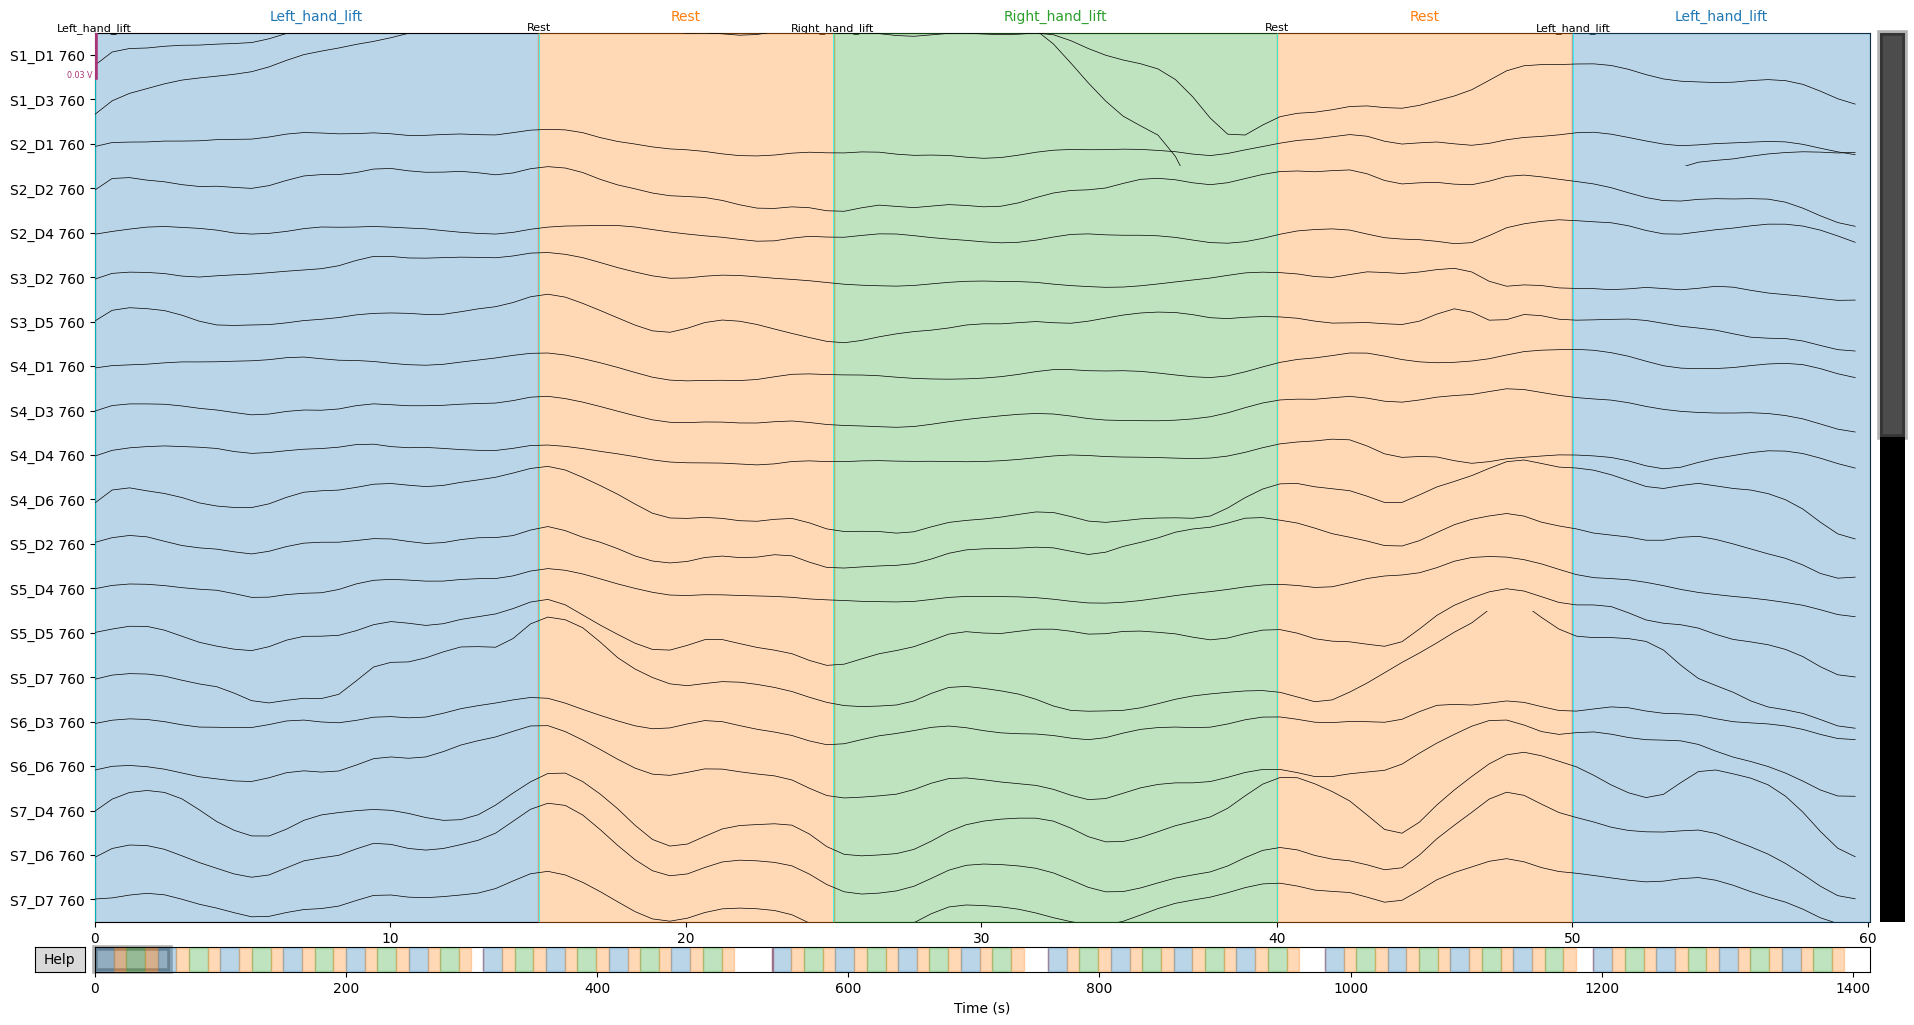

Writing c:\Users\PC\OneDrive - Universidad de Deusto\Documentos\nirs_web_app\nirs-analysis-backend\uploads\Combined_L_Rest_R_Data_raw.fif.gz
Closing c:\Users\PC\OneDrive - Universidad de Deusto\Documentos\nirs_web_app\nirs-analysis-backend\uploads\Combined_L_Rest_R_Data_raw.fif.gz
[done]

Combined file saved successfully to 'nirs-analysis-backend/uploads/Combined_L_Rest_R_Data_raw.fif.gz'!


In [1]:
import os
import traceback
import mne
import numpy as np
from mne.preprocessing.nirs import optical_density
import matplotlib.pyplot as plt

# Paths to the .snirf files
file_paths = [
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_006\2025-04-29_006.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_002\2025-04-29_002.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_003\2025-04-29_003.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_004\2025-04-29_004.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_005\2025-04-29_005.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250501T092740Z-1-001\2025-04-29_007\2025-04-29_007.snirf',
]
# 1 = Left hand lift
# 2 = Rest
# 3 = Right hand lift
event_map = {
    1: 'Left_hand_lift',
    2: 'Rest',
    3: 'Right_hand_lift'
}
# We will apply this structure consistently, potentially overriding original file tasks
# if manual generation is needed.

# List to store processed data
processed_raws = []

# Process each file
for i, file_path in enumerate(file_paths):
    file_name = os.path.basename(file_path)
    print(f"\nProcessing file {i+1}: {file_name}")

    try:
        # Load the SNIRF file
        raw = mne.io.read_raw_snirf(file_path, preload=True)
        print(f"  Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"  Channels: {len(raw.info['ch_names'])} channels")
        print(f"  Duration: {raw.times[-1]:.2f} seconds")

        # Extract existing events from the SNIRF file if they exist
        events_from_snirf = None
        try:
            # Attempt to extract, but we will likely overwrite with our standard pattern
            events_from_snirf, original_event_id = mne.events_from_annotations(raw)
            print(f"  Events found in file: {len(events_from_snirf)}")
            print(f"  Original event types found: {original_event_id}")
            # Decide if you want to keep original events or always overwrite
            # For consistency, let's always generate manually for this example
            events_from_snirf = None # Force manual generation
            print("  -> Forcing manual event generation for consistency.")
        except Exception as e:
            print(f"  Could not extract events automatically: {e}")

        # --- MODIFICATION: Generate events manually with the new structure ---
        # Always generate manually to ensure the Left(1)/Rest(2)/Right(3) pattern
        # if events_from_snirf is None or len(events_from_snirf) < 3: # Condition removed, always generate
        print("  Generating events manually according to Left(1)/Rest(2)/Right(3) pattern")

        # Total recording duration
        total_duration = raw.times[-1]
        sfreq = raw.info['sfreq']

        # Define block durations
        left_duration = 15.0
        rest1_duration = 10.0
        right_duration = 15.0
        rest2_duration = 10.0
        cycle_duration = left_duration + rest1_duration + right_duration + rest2_duration # 50 seconds

        # Calculate onsets for the start of each cycle
        # Ensure we don't start a cycle that can't finish
        cycle_starts = np.arange(0, total_duration - cycle_duration + 1e-6, cycle_duration) # Add small epsilon

        # Create annotations
        all_onsets = []
        all_durations = []
        all_descriptions = []

        for start in cycle_starts:
            # Check if the full cycle fits within the recording duration
            if start + cycle_duration <= total_duration + 1e-6: # Add epsilon for float comparison
                # 1. Left Hand Lift
                all_onsets.append(start)
                all_durations.append(left_duration)
                all_descriptions.append(event_map[1]) # 'Left_hand_lift'

                # 2. Rest
                all_onsets.append(start + left_duration)
                all_durations.append(rest1_duration)
                all_descriptions.append(event_map[2]) # 'Rest'

                # 3. Right Hand Lift
                all_onsets.append(start + left_duration + rest1_duration)
                all_durations.append(right_duration)
                all_descriptions.append(event_map[3]) # 'Right_hand_lift'

                # 4. Rest
                all_onsets.append(start + left_duration + rest1_duration + right_duration)
                all_durations.append(rest2_duration)
                all_descriptions.append(event_map[2]) # 'Rest'
            else:
                 print(f"  Skipping incomplete cycle starting near {start:.1f}s")


        # Create and add the annotations
        if all_onsets:
            annotations = mne.Annotations(onset=np.array(all_onsets),
                                         duration=np.array(all_durations),
                                         description=all_descriptions)
            raw.set_annotations(annotations)
            print(f"  Added {len(annotations)} annotations manually")
        else:
            print("  WARNING: Recording too short to generate any full event cycles.")
        # --- END MODIFICATION ---

        # Convert to optical density
        raw_od = optical_density(raw)

        # Filter (optional - adjust as needed)
        # Consider if filtering is appropriate before or after OD conversion
        raw_od.filter(0.01, 0.5, picks='fnirs', method='iir', verbose=False)

        # Add to the list of processed
        processed_raws.append(raw_od)
        print(f"  ✓ File processed successfully")

    except Exception as e:
        print(f"  ERROR processing file {file_name}: {e}")
        traceback.print_exc() # Print detailed error

# Check if there is processed data before continuing
if not processed_raws:
    raise ValueError("No files were successfully processed to combine")

# Check if sampling frequencies are the same
sfreqs = [raw.info['sfreq'] for raw in processed_raws]
if len(set(sfreqs)) > 1:
    # Option 1: Raise error (current behavior)
    # raise ValueError(f"Sampling frequencies do not match between files: {sfreqs}")
    # Option 2: Resample files to a common frequency (e.g., the lowest)
    target_sfreq = min(sfreqs)
    print(f"\nWARNING: Sampling frequencies differ {sfreqs}. Resampling all to {target_sfreq} Hz.")
    for i in range(len(processed_raws)):
        if processed_raws[i].info['sfreq'] != target_sfreq:
            print(f"  Resampling file {i+1}...")
            processed_raws[i].resample(target_sfreq, npad='auto', verbose=False)
elif not sfreqs:
     raise ValueError("Could not determine sampling frequencies.")
else:
    print(f"\nAll files have consistent sampling frequency: {sfreqs[0]} Hz")

# Merge the files
print("\nAttempting to merge processed files...")
merged_raw = mne.concatenate_raws(processed_raws, preload=True, verbose=False)
print("Files merged successfully.")

# Visualize the resulting annotations
print("\nAnnotations in the combined file:")
if merged_raw.annotations:
    for i, annot in enumerate(merged_raw.annotations):
        print(f"{i+1}. '{annot['description']}' - start: {annot['onset']:.1f}s, duration: {annot['duration']:.1f}s")

    # Visualize the events in the combined file
    try:
        events, event_id_map = mne.events_from_annotations(merged_raw)
        print("\nEvent ID map for plotting:", event_id_map)
        fig = merged_raw.plot(events=events,
                               event_id=event_id_map,
                               duration=60,
                               scalings='auto',
                               title='Events in combined data (Left=1, Rest=2, Right=3)',
                               show_scrollbars=True,
                               block=False) # Set block=False for non-blocking plot in scripts
        # plt.tight_layout() # May cause issues with MNE plots
        plt.show()
    except Exception as e:
         print(f"\nCould not plot events: {e}")
else:
    print("No annotations found in the merged file.")

# Save the merged file in .fif format (compressed)
output_dir = 'nirs-analysis-backend/uploads/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, 'Combined_L_Rest_R_Data_raw.fif.gz')
merged_raw.save(output_path, overwrite=True)

print(f"\nCombined file saved successfully to '{output_path}'!")